In [2]:
%matplotlib inline


Fast Similarity Queries with Annoy and Word2Vec
===============================================

Introduces the Annoy library for similarity queries on top of vectors learned by Word2Vec.



In [3]:
LOGS = False  # Set to True if you want to see progress in logs.
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The `Annoy "Approximate Nearest Neighbors Oh Yeah"
<https://github.com/spotify/annoy>`_ library enables similarity queries with
a Word2Vec model.  The current implementation for finding k nearest neighbors
in a vector space in Gensim has linear complexity via brute force in the
number of indexed documents, although with extremely low constant factors.
The retrieved results are exact, which is an overkill in many applications:
approximate results retrieved in sub-linear time may be enough. Annoy can
find approximate nearest neighbors much faster.

Outline
-------

1. Download Text8 Corpus
2. Train the Word2Vec model
3. Construct AnnoyIndex with model & make a similarity query
4. Compare to the traditional indexer
5. Persist indices to disk
6. Save memory by via memory-mapping indices saved to disk
7. Evaluate relationship of ``num_trees`` to initialization time and accuracy
8. Work with Google's word2vec C formats




1. Download Text8 corpus
------------------------



In [4]:
import gensim.downloader as api
text8_path = api.load('text8', return_path=True)
print("Using corpus from", text8_path)

[=====================================-------------] 74.0% 23.4/31.6MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2. Train the Word2Vec model
---------------------------

For more details, see `sphx_glr_auto_examples_tutorials_run_word2vec.py`.



In [6]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison
params = {
    'alpha': 0.05,
    'vector_size': 10,
    'window': 5,
    'epochs': 1,
    'min_count': 5,
    'sample': 1e-4,
    'sg': 1,
    'hs': 0,
    'negative': 5,
}
model = Word2Vec(Text8Corpus(text8_path), **params)
wv = model.wv
print("Using trained model", wv)

Using trained model KeyedVectors<vector_size=10, 71290 keys>


3. Construct AnnoyIndex with model & make a similarity query
------------------------------------------------------------

An instance of ``AnnoyIndexer`` needs to be created in order to use Annoy in Gensim.
The ``AnnoyIndexer`` class is located in ``gensim.similarities.annoy``.

``AnnoyIndexer()`` takes two parameters:

* **model**: A ``Word2Vec`` or ``Doc2Vec`` model.
* **num_trees**: A positive integer. ``num_trees`` effects the build
  time and the index size. **A larger value will give more accurate results,
  but larger indexes**. More information on what trees in Annoy do can be found
  `here <https://github.com/spotify/annoy#how-does-it-work>`__. The relationship
  between ``num_trees``\ , build time, and accuracy will be investigated later
  in the tutorial.

Now that we are ready to make a query, lets find the top 5 most similar words
to "science" in the Text8 corpus. To make a similarity query we call
``Word2Vec.most_similar`` like we would traditionally, but with an added
parameter, ``indexer``.

Apart from Annoy, Gensim also supports the NMSLIB indexer. NMSLIB is a similar library to
Annoy – both support fast, approximate searches for similar vectors.




In [7]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model, 100)
# Derive the vector for the word "science" in our model
vector = wv["science"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('science', 1.0)
('encyclopedias', 0.9493046387424826)
('homeopathy', 0.9436000564751477)
('instructional', 0.9433695671435589)
('encyclopedic', 0.9433624758893302)
('sociobiology', 0.9389025619129541)
('studies', 0.9381761482162982)
('textbook', 0.9381577342547511)
('anthropology', 0.9335159019636148)
('aesthetics', 0.9330933073557186)
('publications', 0.9258556831492046)

Exact Neighbors
('science', 1.0)
('encyclopedias', 0.9493046998977661)
('homeopathy', 0.9436001181602478)
('instructional', 0.9433695673942566)
('encyclopedic', 0.9433624744415283)
('sociobiology', 0.9389025568962097)
('studies', 0.9381759762763977)
('textbook', 0.9381577372550964)
('anthropology', 0.9335159063339233)
('aesthetics', 0.9330933094024658)
('publications', 0.9258556962013245)


The closer the cosine similarity of a vector is to 1, the more similar that
word is to our query, which was the vector for "science". There are some
differences in the ranking of similar words and the set of words included
within the 10 most similar words.



4. Compare to the traditional indexer
-------------------------------------



In [8]:
# Set up the model and vector that we are using in the comparison
annoy_index = AnnoyIndexer(model, 100)

# Dry run to make sure both indexes are fully in RAM
normed_vectors = wv.get_normed_vectors()
vector = normed_vectors[0]
wv.most_similar([vector], topn=5, indexer=annoy_index)
wv.most_similar([vector], topn=5)

import time
import numpy as np

def avg_query_time(annoy_index=None, queries=1000):
    """Average query time of a most_similar method over 1000 random queries."""
    total_time = 0
    for _ in range(queries):
        rand_vec = normed_vectors[np.random.randint(0, len(wv))]
        start_time = time.process_time()
        wv.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.process_time() - start_time
    return total_time / queries

queries = 1000

gensim_time = avg_query_time(queries=queries)
annoy_time = avg_query_time(annoy_index, queries=queries)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
speed_improvement = gensim_time / annoy_time
print ("\nAnnoy is {0:.2f} times faster on average on this particular run".format(speed_improvement))

Gensim (s/query):	0.01285
Annoy (s/query):	0.00110

Annoy is 11.65 times faster on average on this particular run


**This speedup factor is by no means constant** and will vary greatly from
run to run and is particular to this data set, BLAS setup, Annoy
parameters(as tree size increases speedup factor decreases), machine
specifications, among other factors.

.. Important::
   Initialization time for the annoy indexer was not included in the times.
   The optimal knn algorithm for you to use will depend on how many queries
   you need to make and the size of the corpus. If you are making very few
   similarity queries, the time taken to initialize the annoy indexer will be
   longer than the time it would take the brute force method to retrieve
   results. If you are making many queries however, the time it takes to
   initialize the annoy indexer will be made up for by the incredibly fast
   retrieval times for queries once the indexer has been initialized

.. Important::
   Gensim's 'most_similar' method is using numpy operations in the form of
   dot product whereas Annoy's method isnt. If 'numpy' on your machine is
   using one of the BLAS libraries like ATLAS or LAPACK, it'll run on
   multiple cores (only if your machine has multicore support ). Check `SciPy
   Cookbook
   <http://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html>`_
   for more details.




5. Persisting indices to disk
-----------------------------

You can save and load your indexes from/to disk to prevent having to
construct them each time. This will create two files on disk, *fname* and
*fname.d*. Both files are needed to correctly restore all attributes. Before
loading an index, you will have to create an empty AnnoyIndexer object.




In [17]:
# class W2VWrapper():
#     def __init__():
#         pass
    
#     def save_model():
#         pass
    
#     def load_model():
#         pass
    
#     def most_similar():
#         pass
    

In [9]:
fname = '/tmp/mymodel.index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
import os.path
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

# Results should be identical to above
vector = wv["science"]
approximate_neighbors2 = wv.most_similar([vector], topn=11, indexer=annoy_index2)
for neighbor in approximate_neighbors2:
    print(neighbor)

assert approximate_neighbors == approximate_neighbors2

('science', 1.0)
('encyclopedias', 0.9493046387424826)
('homeopathy', 0.9436000564751477)
('instructional', 0.9433695671435589)
('encyclopedic', 0.9433624758893302)
('sociobiology', 0.9389025619129541)
('studies', 0.9381761482162982)
('textbook', 0.9381577342547511)
('anthropology', 0.9335159019636148)
('aesthetics', 0.9330933073557186)
('publications', 0.9258556831492046)


Be sure to use the same model at load that was used originally, otherwise you
will get unexpected behaviors.




6. Save memory via memory-mapping indexes saved to disk
-------------------------------------------------------

Annoy library has a useful feature that indices can be memory-mapped from
disk. It saves memory when the same index is used by several processes.

Below are two snippets of code. First one has a separate index for each
process. The second snipped shares the index between two processes via
memory-mapping. The second example uses less total RAM as it is shared.




In [10]:
# Remove verbosity from code below (if logging active)
if LOGS:
    logging.disable(logging.CRITICAL)

from multiprocessing import Process
import os
import psutil

Bad example: two processes load the Word2vec model from disk and create their
own Annoy index from that model.




In [11]:
model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model.wv["science"]
    annoy_index = AnnoyIndexer(new_model, 100)
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Create and run two parallel processes to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 12756

Memory used by process 12756: pmem(rss=493502464, vms=2698186752, shared=11108352, text=2318336, lib=0, data=1009573888, dirty=0)
---
Process Id: 12773

Memory used by process 12773: pmem(rss=492593152, vms=2698186752, shared=10940416, text=2318336, lib=0, data=1009614848, dirty=0)
---


Good example: two processes load both the Word2vec model and index from disk
and memory-map the index.




In [12]:
model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model.wv["science"]
    annoy_index = AnnoyIndexer()
    annoy_index.load('/tmp/mymodel.index')
    annoy_index.model = new_model
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 12795

Memory used by process 12795: pmem(rss=340615168, vms=2657857536, shared=31666176, text=2318336, lib=0, data=832794624, dirty=0)
---
Process Id: 12804

Memory used by process 12804: pmem(rss=340881408, vms=2657857536, shared=31928320, text=2318336, lib=0, data=832794624, dirty=0)
---


7. Evaluate relationship of ``num_trees`` to initialization time and accuracy
-----------------------------------------------------------------------------




In [13]:
import matplotlib.pyplot as plt

Build dataset of initialization times and accuracy measures:




In [14]:
exact_results = [element[0] for element in wv.most_similar([normed_vectors[0]], topn=100)]

x_values = []
y_values_init = []
y_values_accuracy = []

for x in range(1, 300, 10):
    x_values.append(x)
    start_time = time.time()
    annoy_index = AnnoyIndexer(model, x)
    y_values_init.append(time.time() - start_time)
    approximate_results = wv.most_similar([normed_vectors[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    y_values_accuracy.append(len(set(top_words).intersection(exact_results)))

Plot results:



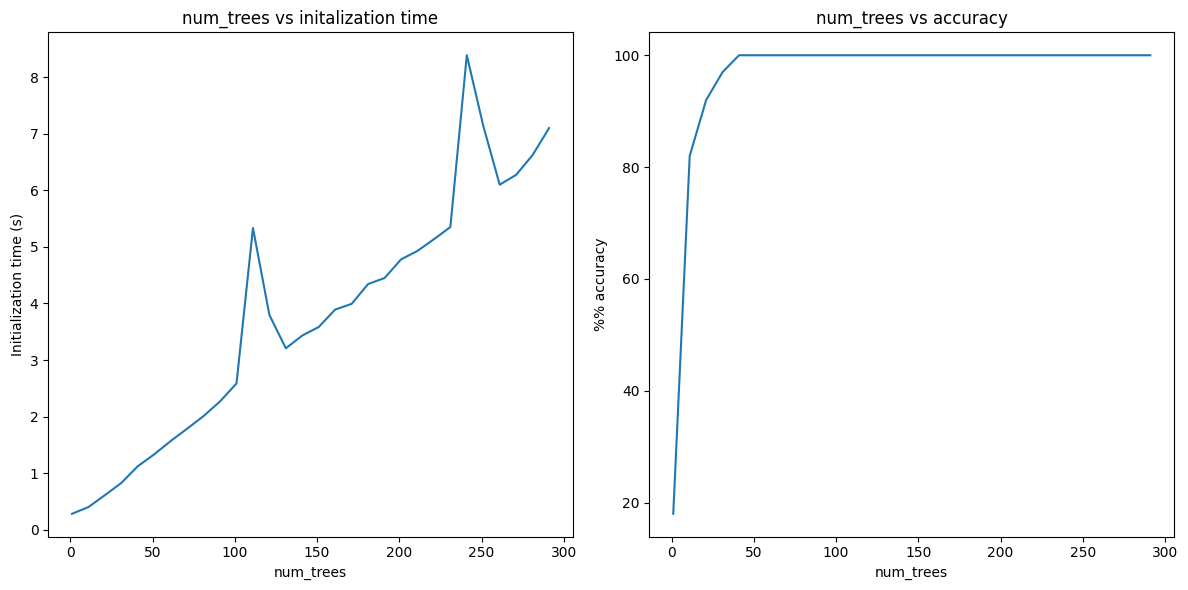

In [15]:
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.plot(x_values, y_values_init)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_trees")
plt.subplot(122)
plt.plot(x_values, y_values_accuracy)
plt.title("num_trees vs accuracy")
plt.ylabel("%% accuracy")
plt.xlabel("num_trees")
plt.tight_layout()
plt.show()

From the above, we can see that the initialization time of the annoy indexer
increases in a linear fashion with num_trees. Initialization time will vary
from corpus to corpus. In the graph above we used the (tiny) Lee corpus.

Furthermore, in this dataset, the accuracy seems logarithmically related to
the number of trees. We see an improvement in accuracy with more trees, but
the relationship is nonlinear.




7. Work with Google's word2vec files
------------------------------------

Our model can be exported to a word2vec C format. There is a binary and a
plain text word2vec format. Both can be read with a variety of other
software, or imported back into Gensim as a ``KeyedVectors`` object.




In [16]:
# To export our model as text
wv.save_word2vec_format('/tmp/vectors.txt', binary=False)

from smart_open import open
# View the first 3 lines of the exported file
# The first line has the total number of entries and the vector dimension count.
# The next lines have a key (a string) followed by its vector.
with open('/tmp/vectors.txt', encoding='utf8') as myfile:
    for i in range(3):
        print(myfile.readline().strip())

# To import a word2vec text model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

# To export a model as binary
wv.save_word2vec_format('/tmp/vectors.bin', binary=True)

# To import a word2vec binary model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)

# To create and save Annoy Index from a loaded `KeyedVectors` object (with 100 trees)
annoy_index = AnnoyIndexer(wv, 100)
annoy_index.save('/tmp/mymodel.index')

# Load and test the saved word vectors and saved Annoy index
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)
annoy_index = AnnoyIndexer()
annoy_index.load('/tmp/mymodel.index')
annoy_index.model = wv

vector = wv["cat"]
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

71290 10
the 0.53598684 0.36340615 -0.2713103 -0.32252476 0.2538079 0.26204574 0.7518833 0.2554594 -0.6491716 -0.24449104
of 0.36448509 0.26489878 -0.43712926 -0.122406214 0.4641894 0.33932003 0.6032263 0.16144615 -0.6762664 -0.223309
Approximate Neighbors
('cat', 1.0)
('bee', 0.9708644759948556)
('ness', 0.9625771019232161)
('eyed', 0.9553386562991975)
('monkey', 0.9462012030762454)
('rabbit', 0.9356936183656503)
('ox', 0.9325055466598928)
('dog', 0.9272012762155941)
('unicorn', 0.9269464516816868)
('bird', 0.9252322332694121)
('frog', 0.9212220891497775)

Exact Neighbors
('cat', 0.9999999403953552)
('bee', 0.970864474773407)
('ness', 0.9625771045684814)
('eyed', 0.9553385972976685)
('monkey', 0.9462011456489563)
('rabbit', 0.935693621635437)
('ox', 0.9325056076049805)
('dog', 0.9272012114524841)
('unicorn', 0.9269462823867798)
('bird', 0.9252322316169739)
('frog', 0.9212221503257751)


Recap
-----

In this notebook we used the Annoy module to build an indexed approximation
of our word embeddings. To do so, we did the following steps:

1. Download Text8 Corpus
2. Train Word2Vec Model
3. Construct AnnoyIndex with model & make a similarity query
4. Persist indices to disk
5. Save memory by via memory-mapping indices saved to disk
6. Evaluate relationship of ``num_trees`` to initialization time and accuracy
7. Work with Google's word2vec C formats


